## Test Image Masking
__Try to replace pure white pixels with other colors__

In [116]:
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image

from sklearn.metrics.pairwise import cosine_similarity
from keras.models import load_model, Model

%matplotlib inline

__Load Models__

In [ ]:
watch_model = load_model('xception_binary_unfrozen_convos1_best.h5')

In [ ]:
layer_name = 'avg_pool'
watch_model_headless = Model(inputs=watch_model.input,
                                 outputs=watch_model.get_layer(layer_name).output)

In [ ]:
watch_df = pd.read_csv('all_watch_info_with_indicators.csv')

In [ ]:
f_path = 'all_pics/'
f_list = os.listdir(f_path)

In [147]:
mask_path = 'all_masks/'
mask_files = os.listdir(mask_path)

In [229]:
def prepare_image(image_name):
    im_watch = Image.open(f_path + starting_name)
    im_watch = im_watch.resize((299,299))
    im_watch_array = np.array(im_watch)
    
    return im_watch_array

In [325]:
def prepare_image_with_mask(image_name, mask_name):
    im_watch = Image.open(image_name)
    im_watch = im_watch.resize((299,299))
    im_watch_array = np.array(im_watch)
    
    im_mask = Image.open(mask_name)
    im_mask = im_mask.resize((299,299))
    im_mask_array = np.array(im_mask)
    
    is_white = (im_watch_array[:,:,0]>252) & \
        (im_watch_array[:,:,1]>250) & \
        (im_watch_array[:,:,1]>250) 
    
    is_white = np.dstack((is_white,is_white,is_white))
    
    im_watch_array[is_white == 1] = im_mask_array[is_white == 1]
    
    return im_watch_array

In [326]:
watch_f = f_path + np.random.choice(f_list)
mask_f =  mask_path + np.random.choice(mask_files)

In [327]:
im_watch_array = prepare_image_with_mask(watch_f,mask_f)

(-0.5, 298.5, 298.5, -0.5)

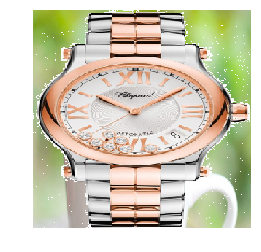

In [328]:
imgplot = plt.imshow(im_watch_array)
plt.axis('off')


__Test Recommendations__

In [ ]:
good_files = []
for filename in glob.iglob('multi_class_testing/**/**/*.jpg', recursive=True):
    good_files.append(filename)

In [ ]:
good_files = list(set(good_files))

Make Feature Vectors

In [ ]:
if 'xception_binary_feature_vectors.npy' not in os.listdir():
    fvec_dict = dict()

    for ix, g_f in enumerate(good_files):
        img = prepare_image(g_f)
        k = g_f.split('/')[-1].split('_')[-1].split('.')[0]
        v = watch_model_headless.predict(img)
        fvec_dict[k] =v  

    #Make Lists of file names and feature vectors
    watch_names = []
    fvec_list = []
    for k, v in fvec_dict.items():
        watch_names.append(k)
        fvec_list.append(v[0])

    #Save Files
    # Numeric Features
    f_vecs = np.asarray(fvec_list)
    np.save('xception_binary_feature_vectors.npy',fvec_array)
    
    # File Names
    watch_names = pd.DataFrame(watch_names,columns=['file_name'])
    watch_names.to_csv(
        'xception_binary_watch_names.csv',index = False)
    
else:
    f_vecs = np.load('xception_binary_feature_vectors.npy')
    watch_names = pd.read_csv('xception_binary_watch_names.csv',index_col=0)
    watch_names.reset_index(inplace=True)
    
    

In [ ]:
np.shape(f_vecs)

__Compute Cosine Similarities__

In [ ]:
dists = cosine_similarity(f_vecs) 

In [ ]:
np.shape(dists)

In [ ]:
dist_df = pd.DataFrame(data = dists)

In [ ]:
dist_df.index = watch_names['watch_names'].iloc[:]
dist_df.columns = watch_names['watch_names'].iloc[:]

Function for finding n closest matches

In [ ]:
def get_similar(watchs, n=None):
    """
    calculates which watchs are most similar to the watchs provided. Does not return
    the watchs that were provided
    
    Parameters
    ----------
    watchs: list
        some watchs!
    
    Returns
    -------
    ranked_watchs: list
        rank ordered watchs
    """
    watchs = [watch for watch in watchs if watch in dist_df.columns]
    watchs_summed = dist_df[watchs].apply(lambda row: np.sum(row), axis=1)
    watchs_summed = watchs_summed.sort_values(ascending=False)
    ranked_watchs = watchs_summed.index[watchs_summed.index.isin(watchs)==False]
    ranked_watchs = ranked_watchs.tolist()
    if n is None:
        return ranked_watchs
        
    else:
        return ranked_watchs[:n]

Random Image from Watch store Database

In [ ]:
starting_name = np.random.choice(f_list)

__ Get Recommendations__

In [8]:
f_path = 'all_pics/'
f_list = os.listdir(f_path)

(-0.5, 246.5, 399.5, -0.5)

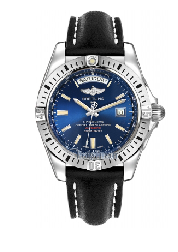

In [9]:
starting_name = np.random.choice(f_list)
img=mpimg.imread(f_path + starting_name)
imgplot = plt.imshow(img)
plt.axis('off')

In [ ]:
n = 6

In [ ]:
img = prepare_image(f_path + starting_name)
out = watch_model_headless.predict(img)
similarities = cosine_similarity(out,f_vecs) 
top_matches = np.array(similarities).argpartition(-n)[0][-n:]

Predict Intended Gender

In [ ]:
watch_df.loc[watch_df['image_name'] == starting_name[:-4]][['image_name','is_male']]

In [ ]:
out = watch_model.predict(img)
out

In [ ]:
recommend_names = dist_df.columns[top_matches]

r = int(np.ceil(n/2))
c = 2
plt.subplots(nrows=r, ncols=c,figsize=(12,20))

for ix, f_name in enumerate(recommend_names):
    plt.subplot(r,c,ix+1)
    img=mpimg.imread(f_path + f_name + '.jpg')
    imgplot = plt.imshow(img)
    plt.axis('off')

__ Open Random Pictures and Test Classification__

In [ ]:
test_path = 'test_pics/'
test_files = os.listdir(test_path)

test_file = test_path + np.random.choice(test_files)
#test_file = test_path + 'blogger-image--2007922873.jpg' #
#test_file = test_path +'Bulgari-Octo-Finissimo-Automatic-Thinnest-Titanium-Sand-Blasted-2017-aBlogtoWatch-22.jpg'
#test_file = test_path +'cocktail_watch.JPG'
#test_file = test_path +'james_bonds_wrist.png'
#test_file = test_path +'ga054-omega-seamaster-planet-ocean-skyfall.jpg'

img2show=mpimg.imread(test_file)
imgplot = plt.imshow(img2show)
plt.axis('off')

In [ ]:
img = prepare_image(test_file)

out = watch_model.predict(img)
print(out)

In [ ]:
out = watch_model_headless.predict(img)
similarities = cosine_similarity(out,f_vecs) 
top_matches = np.array(similarities).argpartition(-n)[0][-n:]

In [ ]:
recommend_names = dist_df.columns[top_matches]

r = int(np.ceil(n/2))
c = 2
plt.subplots(nrows=r, ncols=c,figsize=(12,20))

for ix, f_name in enumerate(recommend_names):
    plt.subplot(r,c,ix+1)
    img=mpimg.imread(f_path + f_name + '.jpg')
    imgplot = plt.imshow(img)
    plt.axis('off')